# 1.24c: Quantum Transition - Classical → Quantum → Frozen

**Purpose:** Characterize token motion by scale using ULP-based classification.

## Three States of Matter

Tokens exist in three regimes based on their displacement relative to the bfloat16 lattice:

1. **Classical Motion** (displacement >> ULP)
   - Smooth, continuous movement in embedding space
   - Gradient-driven dynamics dominate
   - Quantization effects negligible

2. **Quantum Motion** (displacement ≈ ULP)
   - Discrete lattice hopping
   - Displacement is integer multiples of ULP
   - Gradients comparable to quantization threshold

3. **Frozen** (displacement = 0)
   - Complete immobility
   - Gradients below quantization threshold
   - Locked in lattice cells

We'll use per-component ULP to detect which regime each token is in at each timestep.

## Parameters

In [1]:
# Data path
DATA_PATH = "../tensors/Flannel/1.20h_flannel_7.safetensors"
MASK_PATH = "../tensors/Flannel/live_dead_tokens.safetensors"

# Classification thresholds
QUANTUM_FRACTION = 0.7  # Fraction of dimensions that must be lattice-quantized
CLASSICAL_THRESHOLD = 10.0  # Multiple of mean ULP for "classical" motion

# Plot settings
DPI = 200
FIGSIZE = (12, 6)

print("✓ Parameters set")

✓ Parameters set


## Imports

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from safetensors.torch import load_file
from pathlib import Path

print("✓ Imports complete")

✓ Imports complete


## Device Detection

In [3]:
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

print(f"Using device: {device}")

Using device: mps


## Load Data

In [4]:
print("Loading Flannel 7 data...\n")

data = load_file(DATA_PATH)

# Extract W matrix
W = data['W'][0].float()  # (1001, 10000, 64)

# Load token masks
mask_data = load_file(MASK_PATH)
dead_mask = mask_data['dead_mask'].bool()
live_mask = mask_data['live_mask'].bool()

print(f"W shape: {tuple(W.shape)}")
print(f"Dead tokens: {dead_mask.sum().item()}")
print(f"Live tokens: {live_mask.sum().item()}")
print(f"\n✓ Data loaded")

Loading Flannel 7 data...

W shape: (1001, 10000, 64)
Dead tokens: 3699
Live tokens: 6301

✓ Data loaded


## ULP-Based Motion Classification

In [5]:
print("Computing ULP-based motion classification...\n")

# Extract dead tokens
W_dead = W[:, dead_mask, :]  # (1001, 3699, 64)

# Compute per-component ULP for each position
# ULP = 2^(exponent - mantissa_bits)
# For bfloat16: mantissa_bits = 7

# Get exponents using frexp (returns mantissa, exponent)
# frexp: x = mantissa * 2^exponent, where mantissa ∈ [0.5, 1)
_, exponents = torch.frexp(W_dead[:-1].abs())  # (1000, 3699, 64)

# Compute ULP for each element
ulps = 2.0 ** (exponents - 7)  # (1000, 3699, 64)

# Compute displacement vectors
delta_W = W_dead[1:] - W_dead[:-1]  # (1000, 3699, 64)

# Normalize displacements by ULP
normalized_delta = delta_W / (ulps + 1e-10)  # Avoid division by zero

# Check if each component is an integer multiple of ULP
rounded = torch.round(normalized_delta)
is_quantized = torch.abs(normalized_delta - rounded) < 0.1  # Within 10% of integer multiple

# Compute total displacement magnitude (L2 norm)
displacement_norm = torch.norm(delta_W, dim=2)  # (1000, 3699)

# Compute mean ULP per token (as reference scale)
mean_ulp = ulps.mean(dim=2)  # (1000, 3699)

print(f"Displacement vectors: {tuple(delta_W.shape)}")
print(f"ULPs: {tuple(ulps.shape)}")
print(f"Normalized displacements: {tuple(normalized_delta.shape)}")
print(f"\n✓ ULP computation complete")

Computing ULP-based motion classification...

Displacement vectors: (1000, 3699, 64)
ULPs: (1000, 3699, 64)
Normalized displacements: (1000, 3699, 64)

✓ ULP computation complete


## Classify Token States

In [6]:
print("Classifying token states...\n")

# State 1: Frozen (no movement)
frozen_mask = (displacement_norm == 0)  # (1000, 3699)

# State 2: Quantum (lattice-hopping)
# Token is "quantum" if:
# - It's moving (not frozen)
# - Most dimensions are quantized (integer ULP multiples)
# - Displacement is small (< CLASSICAL_THRESHOLD * mean_ulp)
fraction_quantized = is_quantized.float().mean(dim=2)  # (1000, 3699)
is_small = displacement_norm < (CLASSICAL_THRESHOLD * mean_ulp)
quantum_mask = (~frozen_mask) & (fraction_quantized > QUANTUM_FRACTION) & is_small

# State 3: Classical (smooth motion)
# Everything else that's moving
classical_mask = (~frozen_mask) & (~quantum_mask)

# Compute fractions at each timestep
fraction_frozen = frozen_mask.float().mean(dim=1)  # (1000,)
fraction_quantum = quantum_mask.float().mean(dim=1)  # (1000,)
fraction_classical = classical_mask.float().mean(dim=1)  # (1000,)

print(f"Classification complete.")
print(f"\nMean fractions across all timesteps:")
print(f"  Classical: {fraction_classical.mean():.1%}")
print(f"  Quantum:   {fraction_quantum.mean():.1%}")
print(f"  Frozen:    {fraction_frozen.mean():.1%}")
print(f"\n✓ States classified")

Classifying token states...

Classification complete.

Mean fractions across all timesteps:
  Classical: 12.9%
  Quantum:   38.6%
  Frozen:    48.5%

✓ States classified


## Visualization: State Evolution

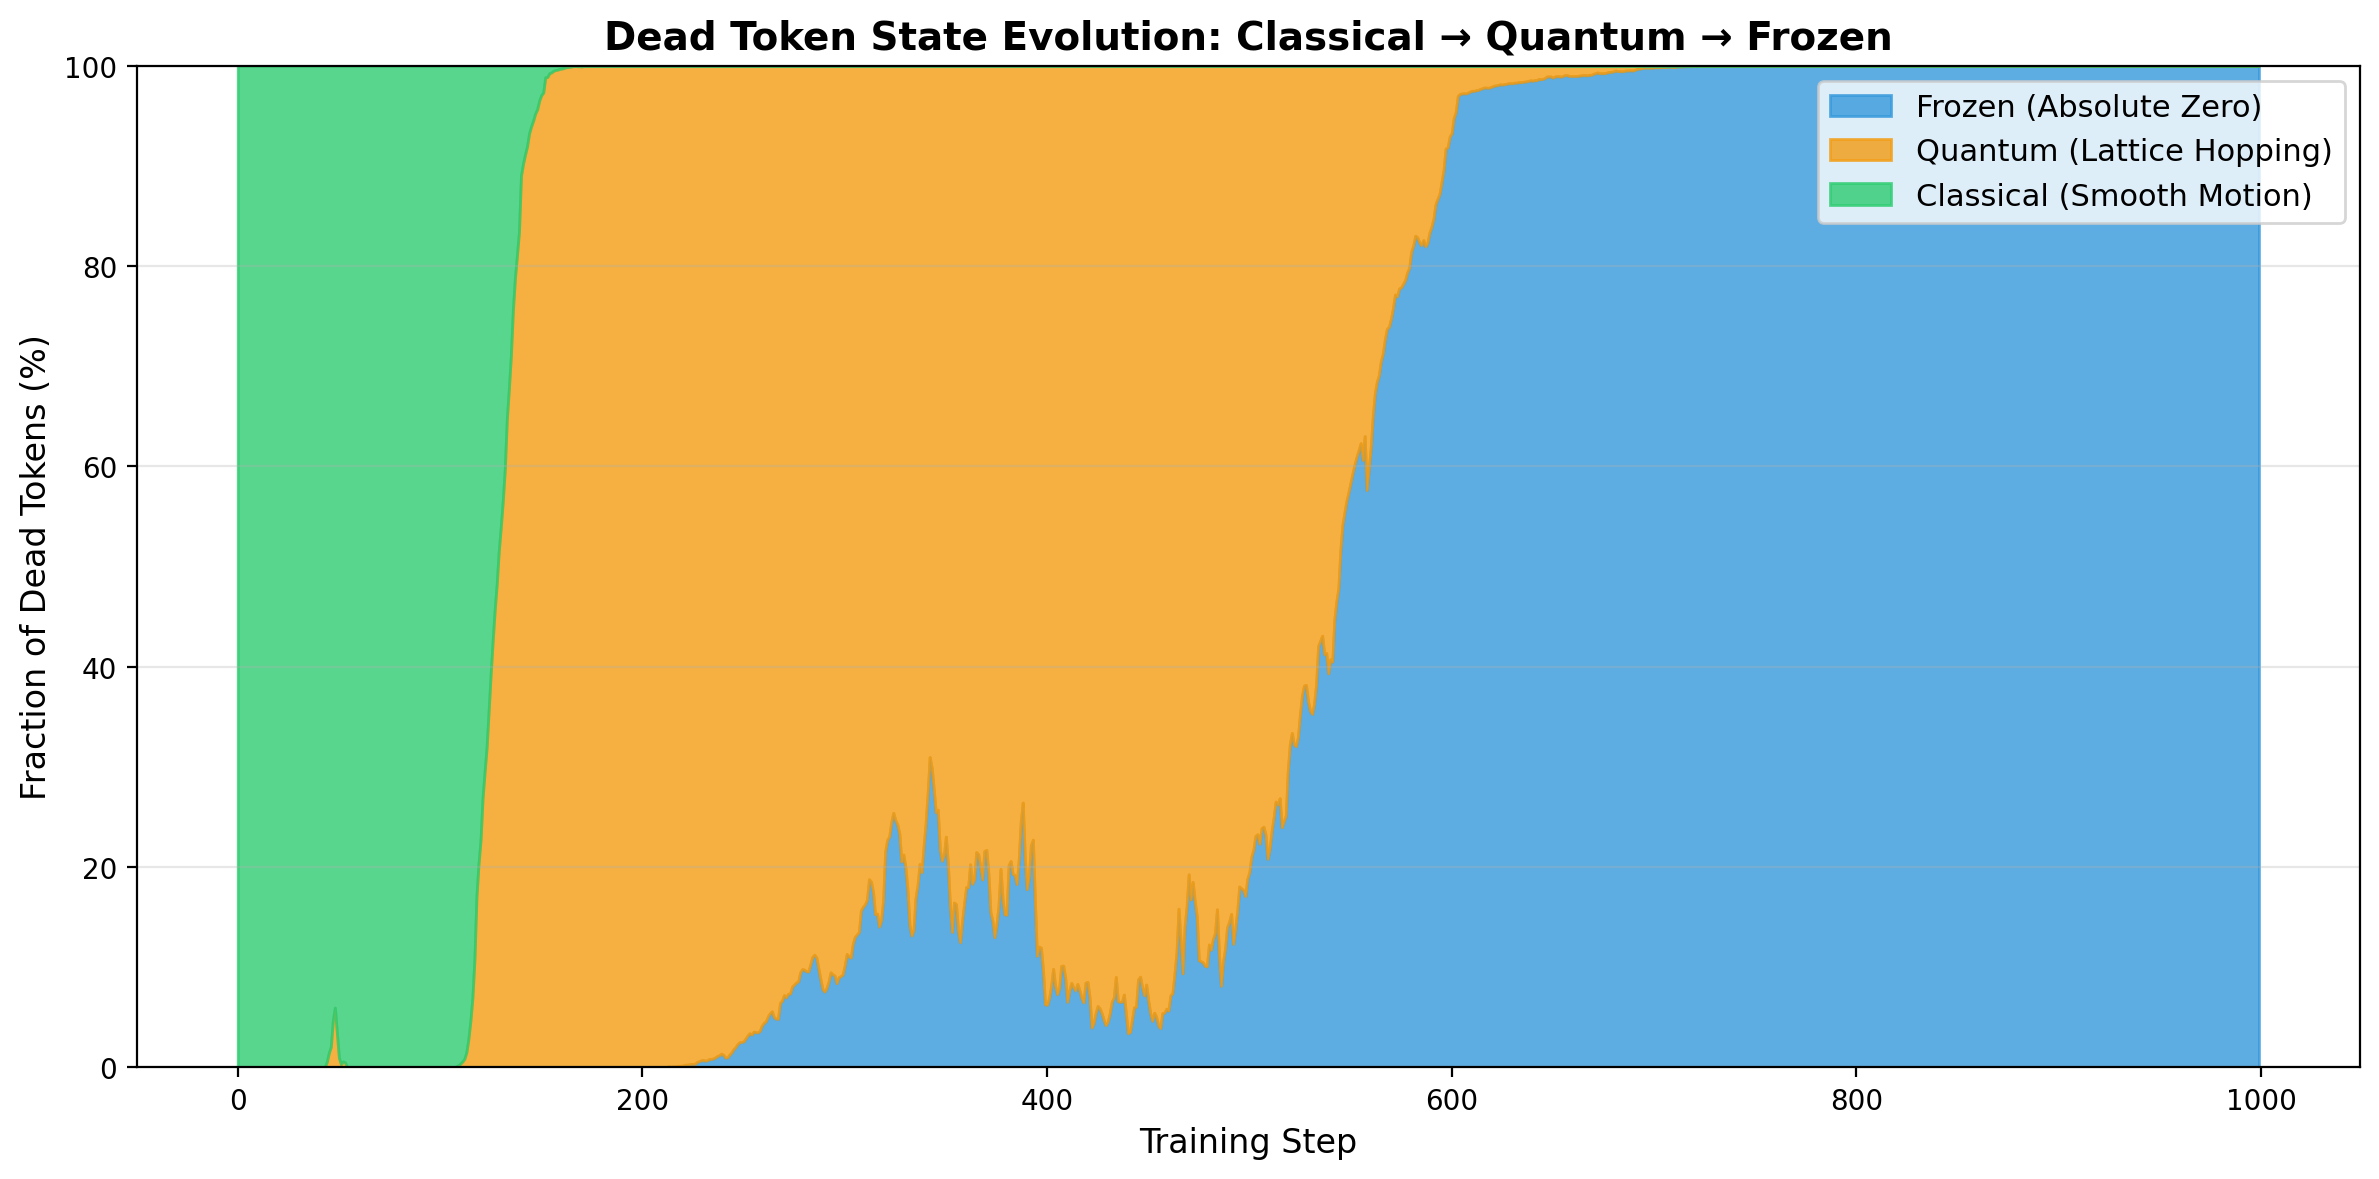

In [7]:
# Main plot: Stacked area showing Classical → Quantum → Frozen
fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)

# Convert to percentages
classical_pct = fraction_classical.numpy() * 100
quantum_pct = fraction_quantum.numpy() * 100
frozen_pct = fraction_frozen.numpy() * 100

# Stacked area
ax.fill_between(range(len(frozen_pct)), 0, frozen_pct, 
                color='#3498db', alpha=0.8, label='Frozen (Absolute Zero)')
ax.fill_between(range(len(frozen_pct)), frozen_pct, frozen_pct + quantum_pct, 
                color='#f39c12', alpha=0.8, label='Quantum (Lattice Hopping)')
ax.fill_between(range(len(frozen_pct)), frozen_pct + quantum_pct, 100, 
                color='#2ecc71', alpha=0.8, label='Classical (Smooth Motion)')

ax.set_xlabel('Training Step', fontsize=12)
ax.set_ylabel('Fraction of Dead Tokens (%)', fontsize=12)
ax.set_title('Dead Token State Evolution: Classical → Quantum → Frozen', fontsize=14, fontweight='bold')
ax.legend(loc='upper right', fontsize=11)
ax.set_ylim(0, 100)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## Classical/Quantum Boundary Analysis

In [8]:
print("="*80)
print("CLASSICAL/QUANTUM BOUNDARY ANALYSIS")
print("="*80 + "\n")

# Find when classical motion ends (< 50% classical)
classical_dominant = fraction_classical > 0.5
if classical_dominant.any():
    t_classical_end = classical_dominant.nonzero()[-1].item()
else:
    t_classical_end = 0

# Find when quantum motion peaks
t_quantum_peak = fraction_quantum.argmax().item()

# Find when quantum motion ends (< 10% quantum)
quantum_significant = fraction_quantum > 0.1
if quantum_significant.any():
    t_quantum_end = quantum_significant.nonzero()[-1].item()
else:
    t_quantum_end = t_quantum_peak

print(f"Classical regime ends:   t={t_classical_end} ({fraction_classical[t_classical_end]:.1%} classical)")
print(f"Quantum regime peaks:    t={t_quantum_peak} ({fraction_quantum[t_quantum_peak]:.1%} quantum)")
print(f"Quantum regime ends:     t={t_quantum_end} ({fraction_quantum[t_quantum_end]:.1%} quantum)")
print(f"\nClassical phase:  t=0 to t={t_classical_end} ({t_classical_end} steps)")
print(f"Quantum phase:    t={t_classical_end} to t={t_quantum_end} ({t_quantum_end - t_classical_end} steps)")
print(f"Frozen phase:     t={t_quantum_end} onward")

print("\n" + "="*80 + "\n")

CLASSICAL/QUANTUM BOUNDARY ANALYSIS

Classical regime ends:   t=128 (51.8% classical)
Quantum regime peaks:    t=171 (100.0% quantum)
Quantum regime ends:     t=596 (10.4% quantum)

Classical phase:  t=0 to t=128 (128 steps)
Quantum phase:    t=128 to t=596 (468 steps)
Frozen phase:     t=596 onward




## Displacement Distribution Evolution

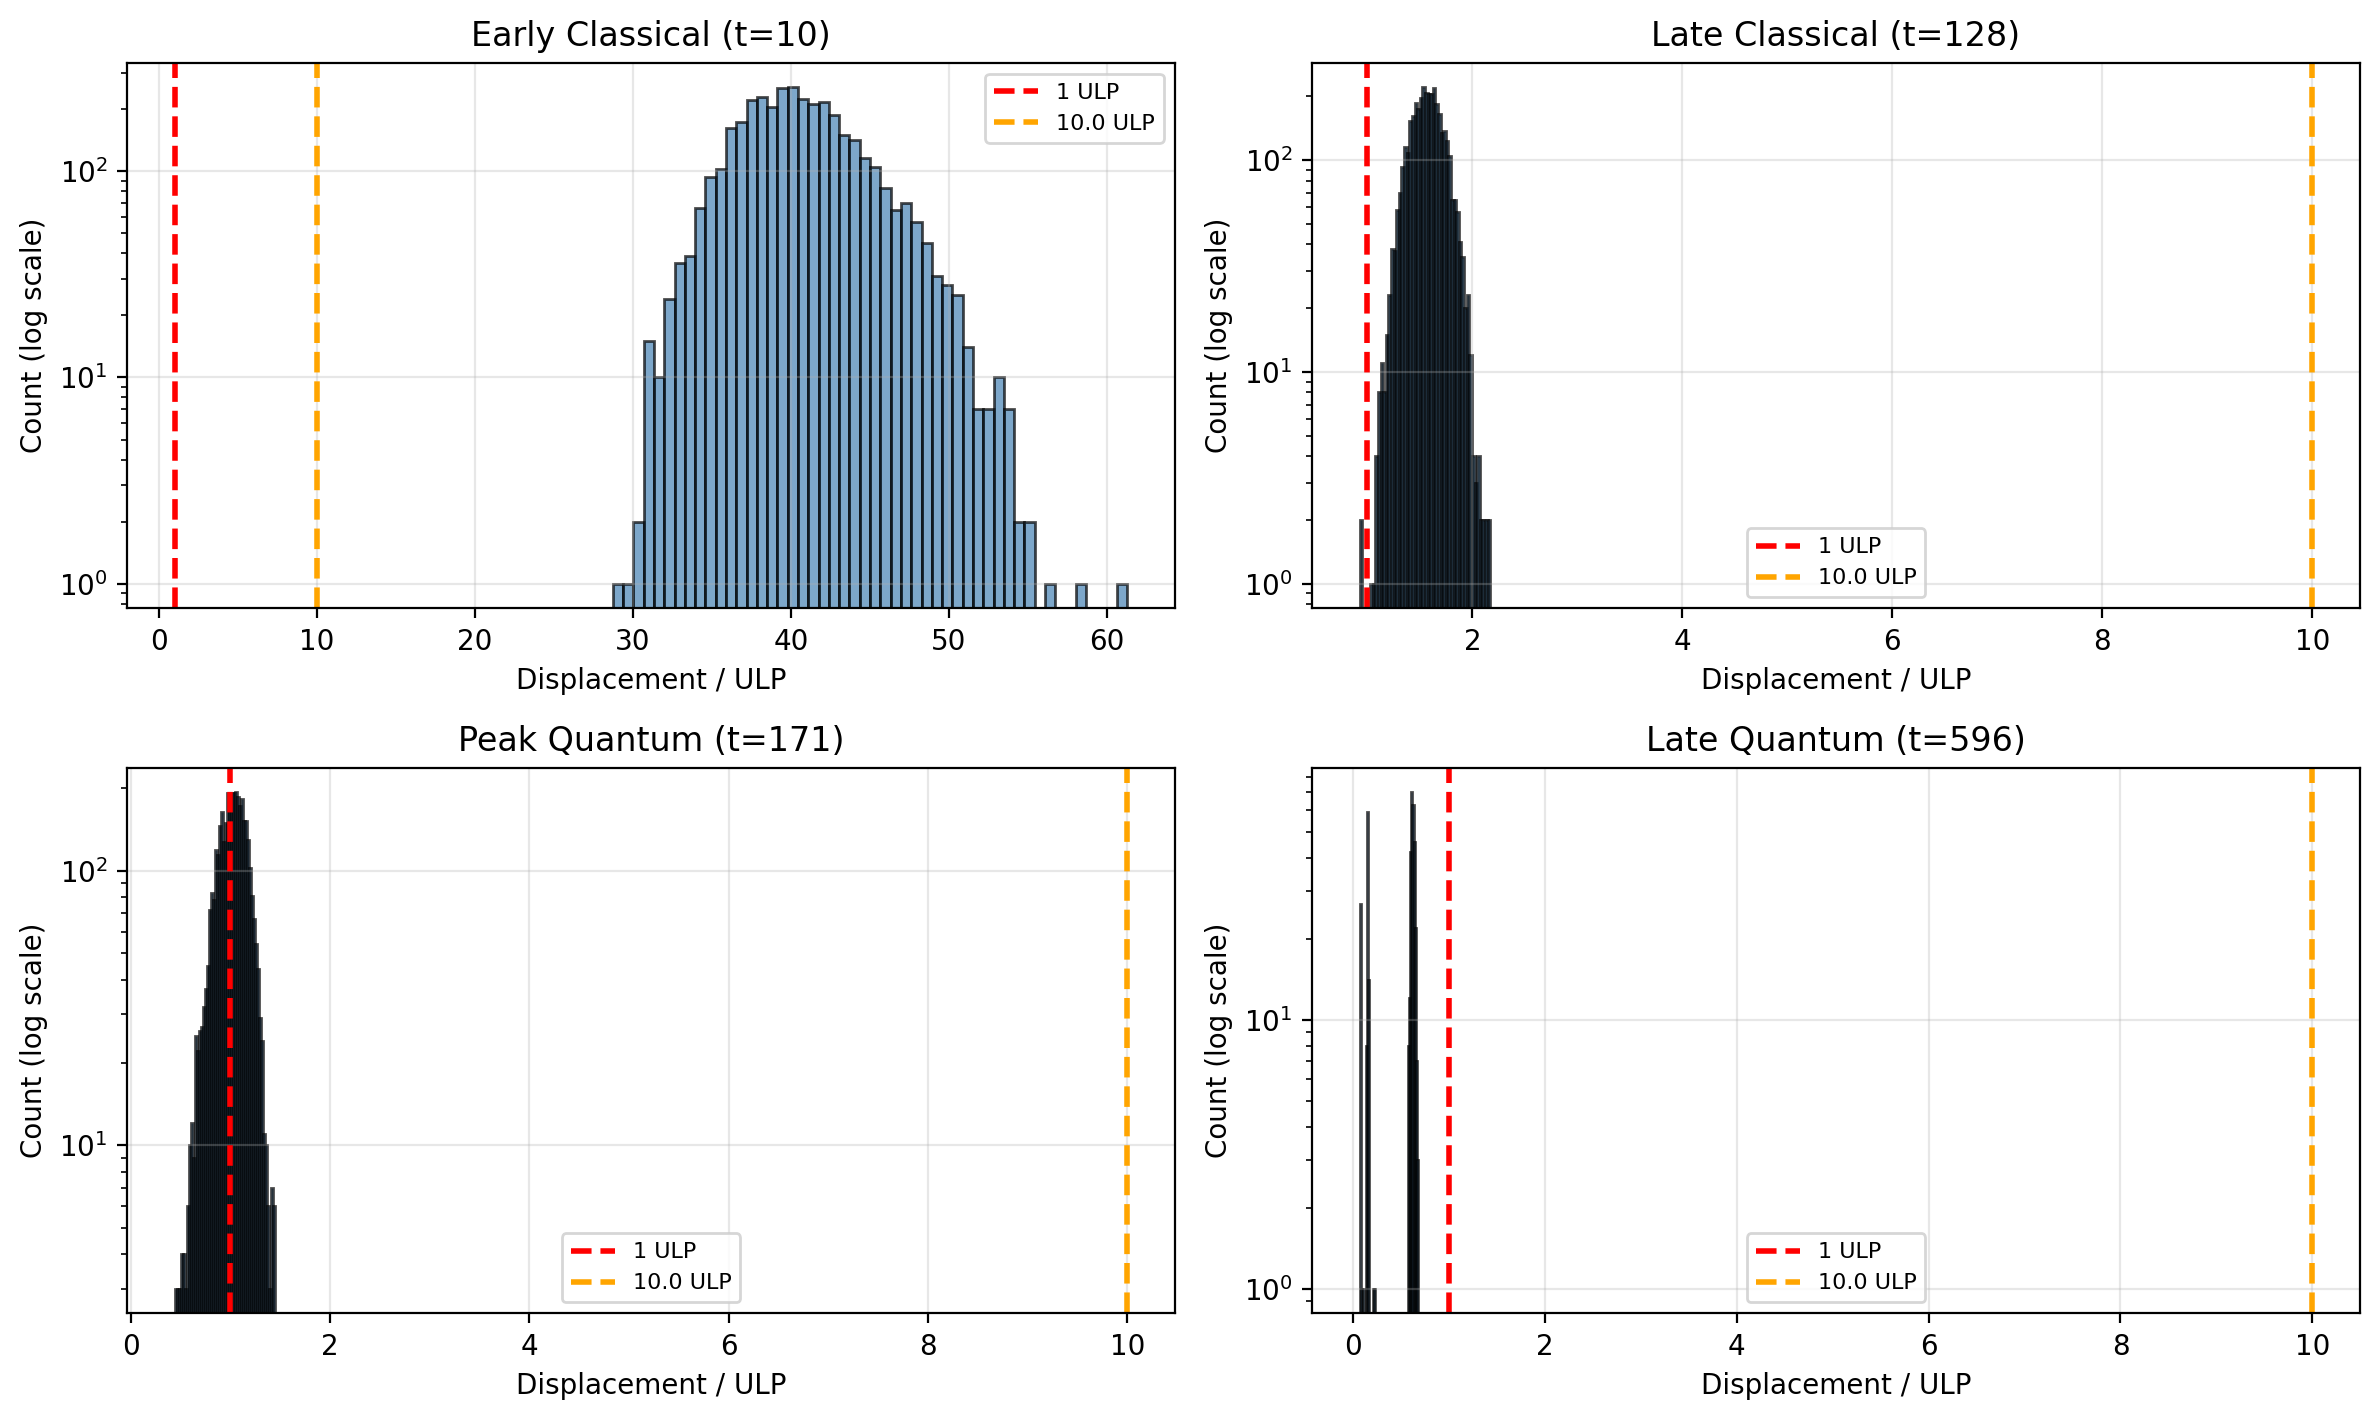

Interpretation:
  Classical: Broad distribution >> 10 ULP (smooth motion)
  Quantum: Peak near 1-10 ULP (lattice hopping)
  Frozen: Empty histogram (no motion)


In [9]:
# Plot displacement distributions at 4 key moments
timepoints = [
    ("Early Classical", 10),
    ("Late Classical", max(10, t_classical_end)),
    ("Peak Quantum", t_quantum_peak),
    ("Late Quantum", t_quantum_end),
]

fig, axes = plt.subplots(2, 2, figsize=(FIGSIZE[0], FIGSIZE[1]*1.2), dpi=DPI)
axes = axes.flatten()

for i, (label, t) in enumerate(timepoints):
    ax = axes[i]
    
    # Get displacements and ULPs at this timestep
    displacements_t = displacement_norm[t].numpy()  # (3699,)
    ulps_t = mean_ulp[t].numpy()  # (3699,)
    
    # Normalize by ULP
    normalized = displacements_t / ulps_t
    
    # Remove frozen tokens
    moving = normalized[normalized > 0]
    
    if len(moving) > 0:
        ax.hist(moving, bins=50, color='steelblue', alpha=0.7, edgecolor='black', log=True)
        ax.axvline(1, color='red', linestyle='--', linewidth=2, label='1 ULP')
        ax.axvline(CLASSICAL_THRESHOLD, color='orange', linestyle='--', linewidth=2, label=f'{CLASSICAL_THRESHOLD} ULP')
        ax.set_xlabel('Displacement / ULP')
        ax.set_ylabel('Count (log scale)')
        ax.set_title(f'{label} (t={t})')
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)
    else:
        ax.text(0.5, 0.5, 'All frozen', ha='center', va='center', transform=ax.transAxes)
        ax.set_title(f'{label} (t={t})')

plt.tight_layout()
plt.show()

print("Interpretation:")
print("  Classical: Broad distribution >> 10 ULP (smooth motion)")
print("  Quantum: Peak near 1-10 ULP (lattice hopping)")
print("  Frozen: Empty histogram (no motion)")

## Per-Component Quantization Analysis

PER-COMPONENT QUANTIZATION ANALYSIS

At peak quantum (t=171):
  Quantum tokens: 3699 (100.0%)
  Mean quantized dimensions: 54.0 / 64 (84.4%)
  Min quantized dimensions:  45 / 64
  Max quantized dimensions:  61 / 64


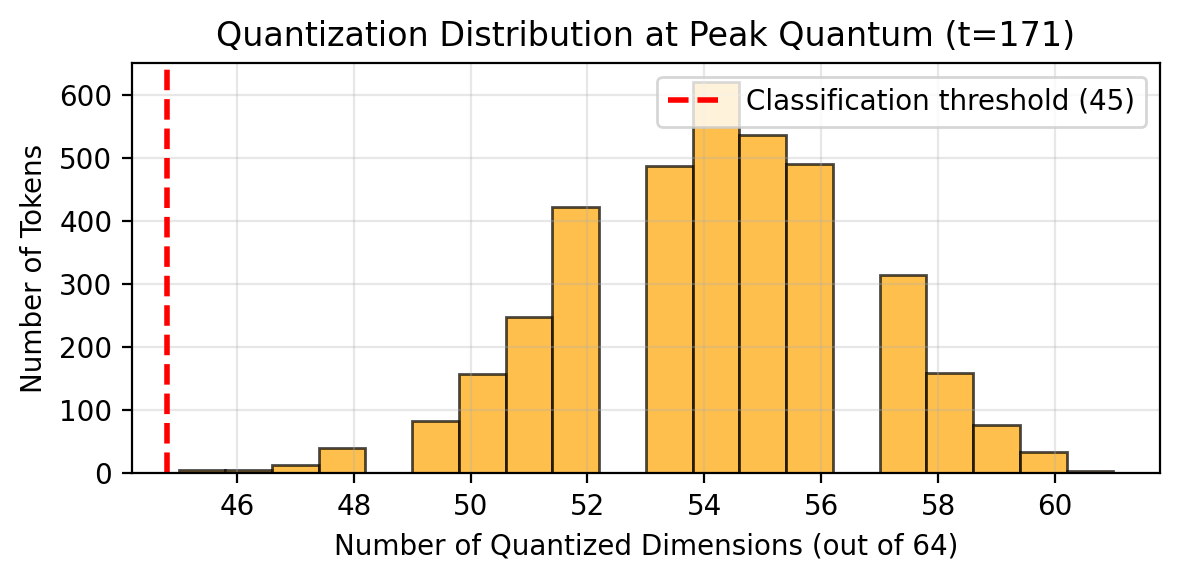

In [10]:
# For tokens in quantum regime, how many dimensions are quantized?
print("="*80)
print("PER-COMPONENT QUANTIZATION ANALYSIS")
print("="*80 + "\n")

# During peak quantum (t_quantum_peak), analyze quantization
t = t_quantum_peak

# Get quantum tokens at this timestep
quantum_tokens = quantum_mask[t]  # (3699,)
n_quantum = quantum_tokens.sum().item()

if n_quantum > 0:
    # For these tokens, what fraction of dimensions are quantized?
    quantum_quantization = is_quantized[t, quantum_tokens, :]  # (n_quantum, 64)
    fraction_per_token = quantum_quantization.float().mean(dim=1)  # (n_quantum,)
    
    print(f"At peak quantum (t={t}):")
    print(f"  Quantum tokens: {n_quantum} ({n_quantum/3699*100:.1f}%)")
    print(f"  Mean quantized dimensions: {fraction_per_token.mean()*64:.1f} / 64 ({fraction_per_token.mean():.1%})")
    print(f"  Min quantized dimensions:  {fraction_per_token.min()*64:.0f} / 64")
    print(f"  Max quantized dimensions:  {fraction_per_token.max()*64:.0f} / 64")
    
    # Histogram
    fig, ax = plt.subplots(figsize=(FIGSIZE[0]//2, FIGSIZE[1]//2), dpi=DPI)
    ax.hist((fraction_per_token * 64).numpy(), bins=20, color='orange', alpha=0.7, edgecolor='black')
    ax.axvline(QUANTUM_FRACTION * 64, color='red', linestyle='--', linewidth=2, 
               label=f'Classification threshold ({QUANTUM_FRACTION*64:.0f})')
    ax.set_xlabel('Number of Quantized Dimensions (out of 64)')
    ax.set_ylabel('Number of Tokens')
    ax.set_title(f'Quantization Distribution at Peak Quantum (t={t})')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print(f"No quantum tokens at t={t}")

print("\n" + "="*80 + "\n")

## Velocity Evolution: Classical vs Quantum

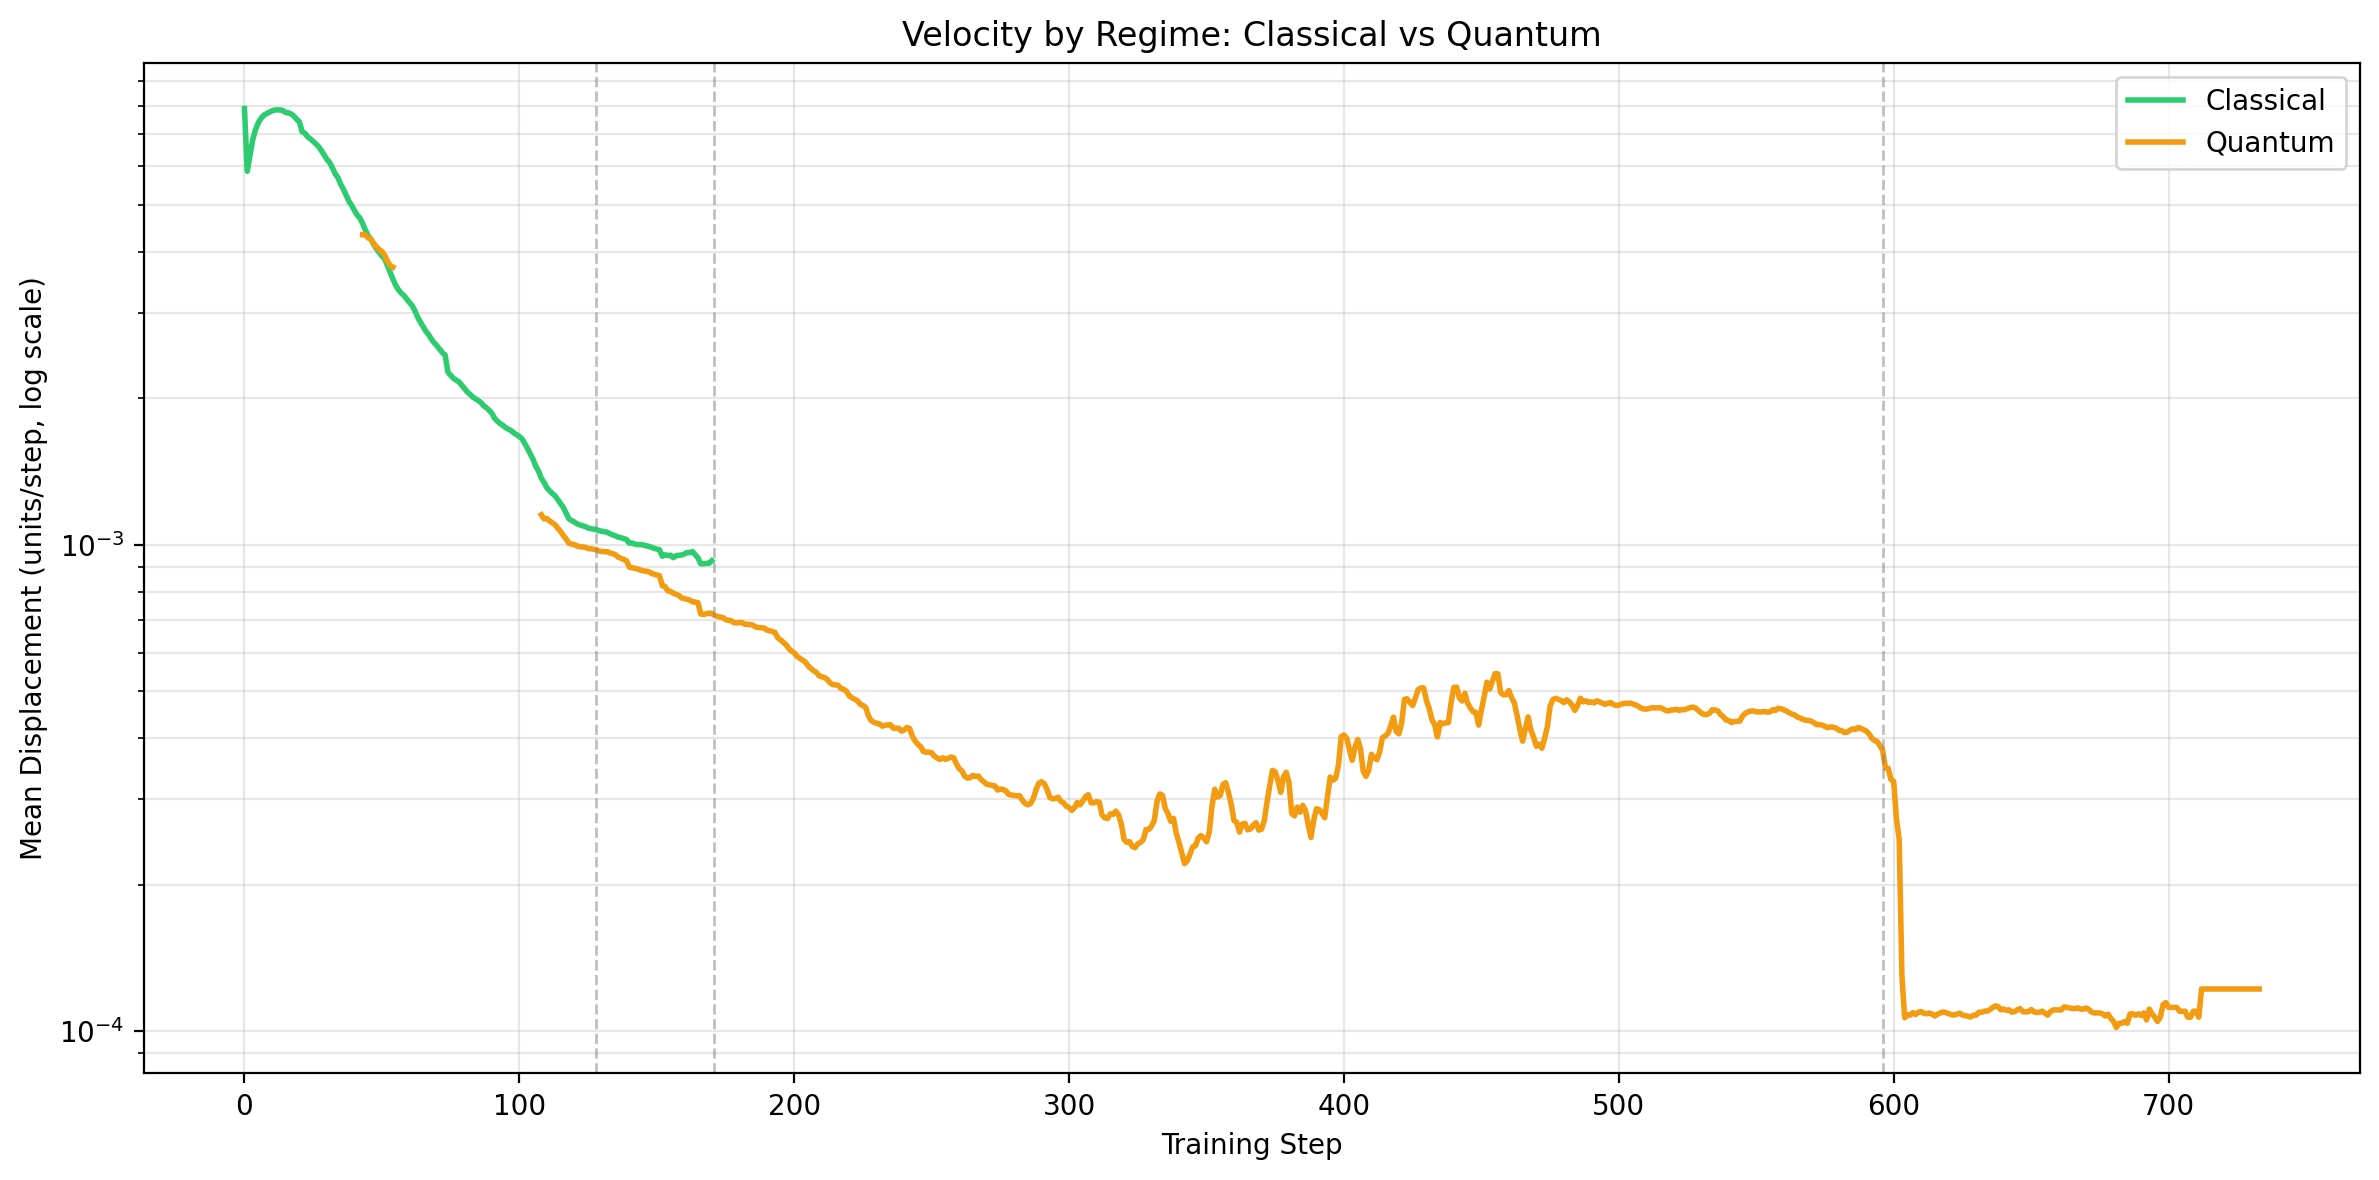

Interpretation: Classical motion is ~10-100× faster than quantum hopping.


In [11]:
# Plot mean displacement over time for each regime
fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)

# Compute mean displacement for each class at each timestep
classical_velocity = torch.where(classical_mask, displacement_norm, torch.tensor(float('nan'))).nanmean(dim=1)
quantum_velocity = torch.where(quantum_mask, displacement_norm, torch.tensor(float('nan'))).nanmean(dim=1)

ax.semilogy(classical_velocity.numpy(), linewidth=2, color='#2ecc71', label='Classical')
ax.semilogy(quantum_velocity.numpy(), linewidth=2, color='#f39c12', label='Quantum')

ax.axvline(t_classical_end, color='gray', linestyle='--', linewidth=1, alpha=0.5)
ax.axvline(t_quantum_peak, color='gray', linestyle='--', linewidth=1, alpha=0.5)
ax.axvline(t_quantum_end, color='gray', linestyle='--', linewidth=1, alpha=0.5)

ax.set_xlabel('Training Step')
ax.set_ylabel('Mean Displacement (units/step, log scale)')
ax.set_title('Velocity by Regime: Classical vs Quantum')
ax.legend()
ax.grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.show()

print("Interpretation: Classical motion is ~10-100× faster than quantum hopping.")

## Transition Dynamics: Classical → Quantum → Frozen

TRANSITION DYNAMICS

Final state distribution (last 100 steps):
  Classical: 0 tokens (0.0%)
  Quantum:   0 tokens (0.0%)
  Frozen:    3699 tokens (100.0%)


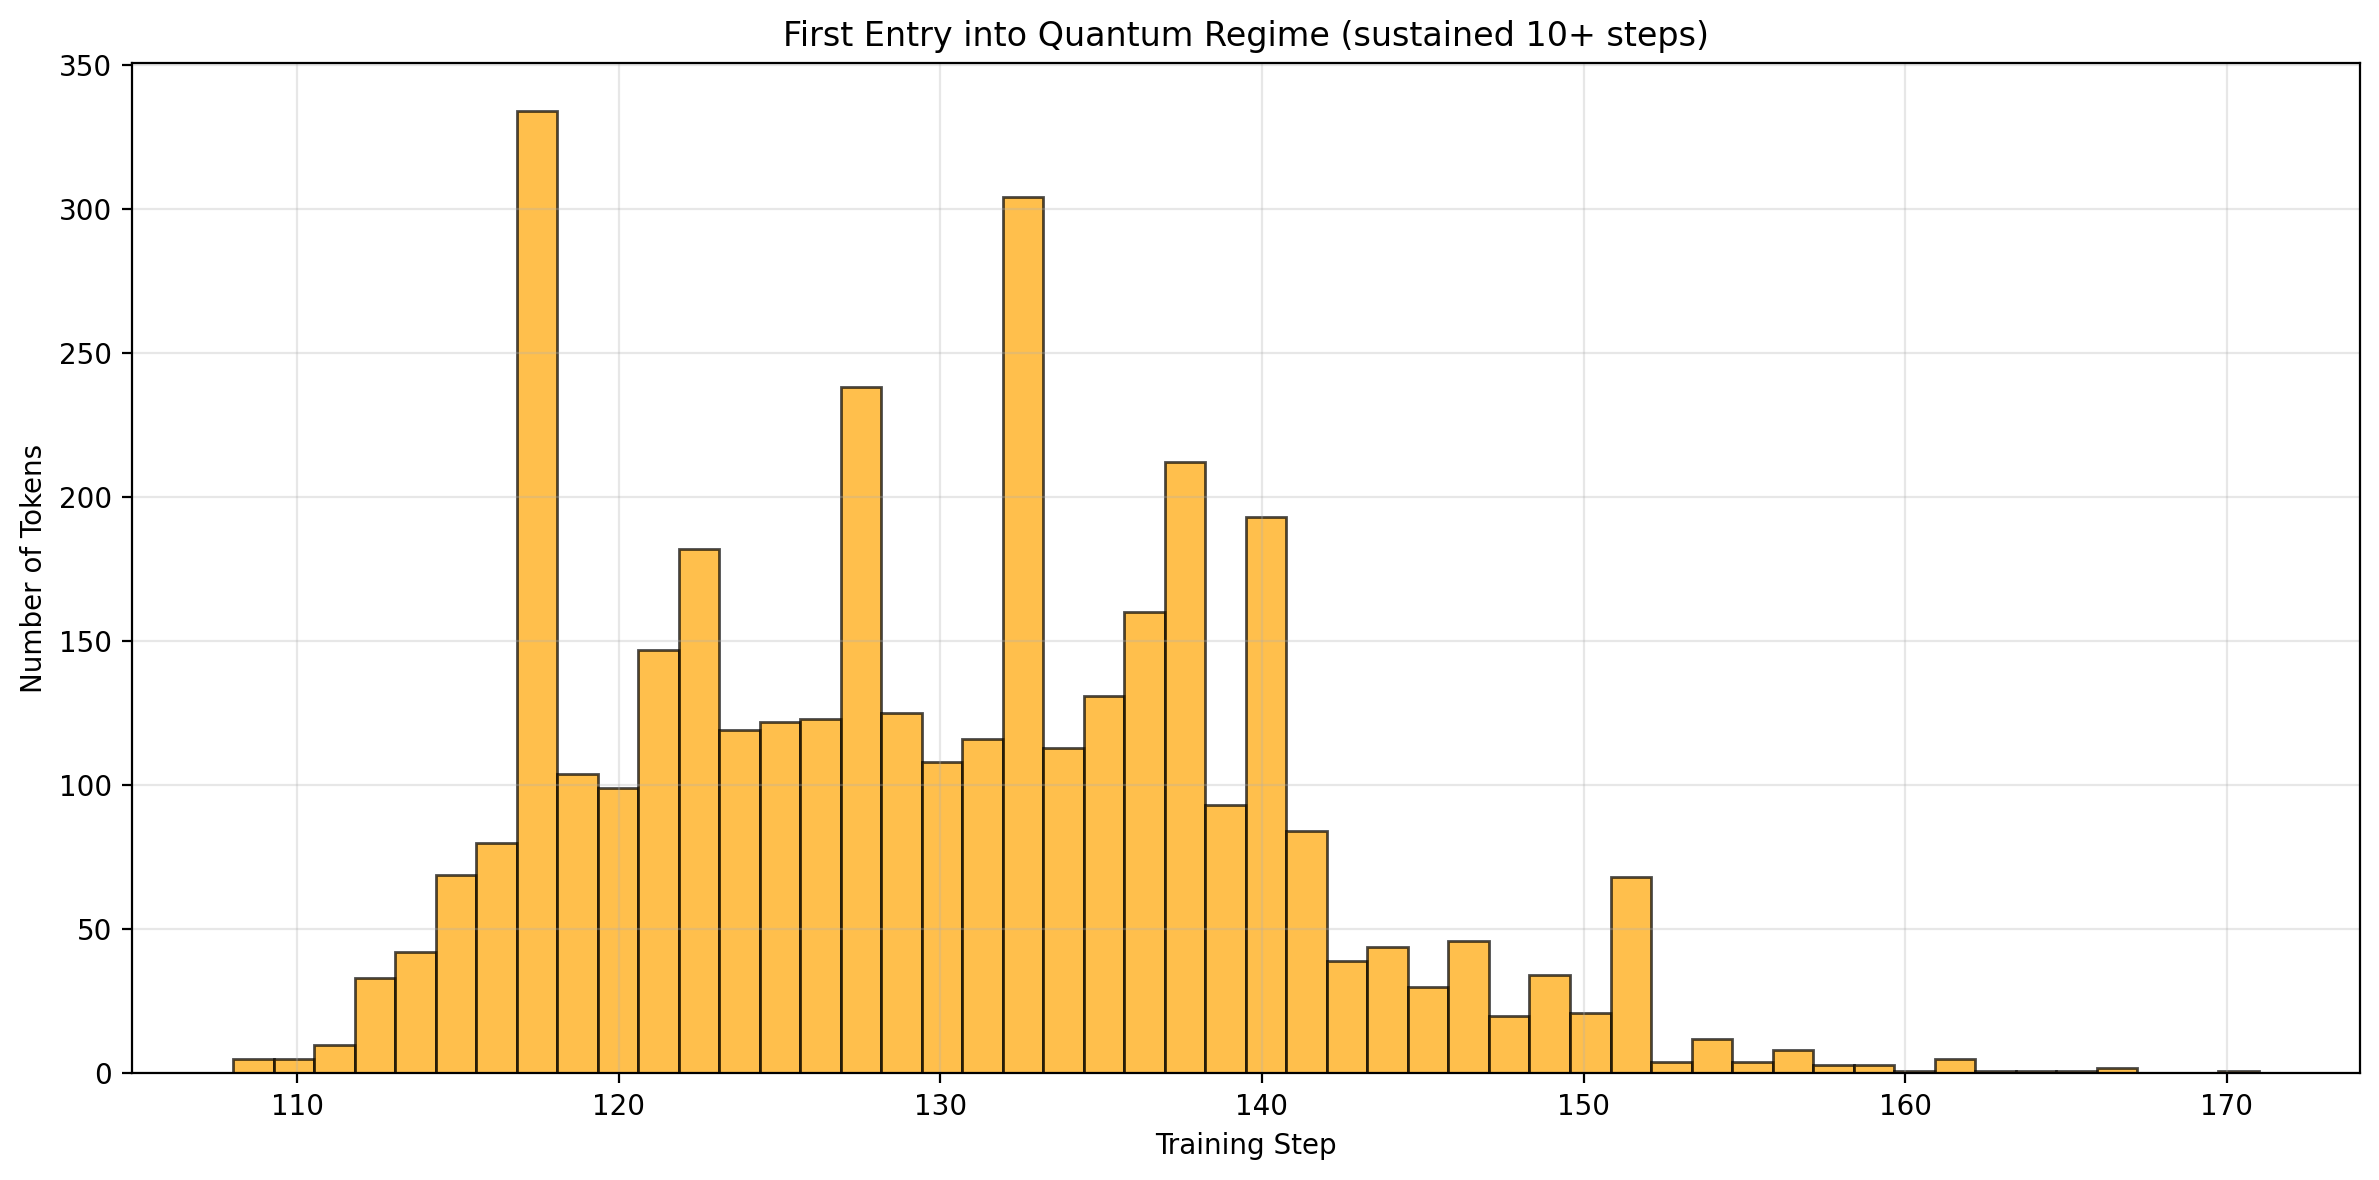


Tokens entering quantum regime: 3699 (100.0%)
  Median entry time: t=130
  Range: t=108 to t=171




In [12]:
# For each token, find when it transitions between states
print("="*80)
print("TRANSITION DYNAMICS")
print("="*80 + "\n")

# Classify each token's final state
# (What state did it spend most time in during last 100 steps?)
final_window = slice(-100, None)

time_in_classical = classical_mask[final_window].float().mean(dim=0)  # (3699,)
time_in_quantum = quantum_mask[final_window].float().mean(dim=0)  # (3699,)
time_in_frozen = frozen_mask[final_window].float().mean(dim=0)  # (3699,)

# Assign final state
states = torch.stack([time_in_classical, time_in_quantum, time_in_frozen], dim=1)  # (3699, 3)
final_state = states.argmax(dim=1)  # 0=classical, 1=quantum, 2=frozen

n_final_classical = (final_state == 0).sum().item()
n_final_quantum = (final_state == 1).sum().item()
n_final_frozen = (final_state == 2).sum().item()

print(f"Final state distribution (last 100 steps):")
print(f"  Classical: {n_final_classical} tokens ({n_final_classical/3699*100:.1f}%)")
print(f"  Quantum:   {n_final_quantum} tokens ({n_final_quantum/3699*100:.1f}%)")
print(f"  Frozen:    {n_final_frozen} tokens ({n_final_frozen/3699*100:.1f}%)")

# Histogram of when tokens first enter quantum regime
# (First timestep where token is quantum for 10+ consecutive steps)
first_quantum = torch.full((3699,), -1, dtype=torch.long)

for token_idx in range(3699):
    quantum_times = quantum_mask[:, token_idx].nonzero(as_tuple=True)[0]
    if len(quantum_times) >= 10:
        # Find first sustained quantum period (10+ consecutive)
        for i in range(len(quantum_times) - 9):
            if torch.all(quantum_times[i:i+10] == torch.arange(quantum_times[i], quantum_times[i]+10)):
                first_quantum[token_idx] = quantum_times[i].item()
                break

valid_quantum_entries = first_quantum[first_quantum >= 0]

if len(valid_quantum_entries) > 0:
    fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)
    ax.hist(valid_quantum_entries.numpy(), bins=50, color='orange', alpha=0.7, edgecolor='black')
    ax.set_xlabel('Training Step')
    ax.set_ylabel('Number of Tokens')
    ax.set_title('First Entry into Quantum Regime (sustained 10+ steps)')
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print(f"\nTokens entering quantum regime: {len(valid_quantum_entries)} ({len(valid_quantum_entries)/3699*100:.1f}%)")
    print(f"  Median entry time: t={valid_quantum_entries.median().item():.0f}")
    print(f"  Range: t={valid_quantum_entries.min().item()} to t={valid_quantum_entries.max().item()}")
else:
    print("\nNo sustained quantum regime detected for individual tokens.")

print("\n" + "="*80 + "\n")

## Summary

In [13]:
print("\n" + "="*80)
print("QUANTUM TRANSITION SUMMARY")
print("="*80 + "\n")

print("Dead tokens undergo three-phase cooling:")
print(f"  1. Classical (smooth):  t=0 to t~{t_classical_end}")
print(f"  2. Quantum (hopping):   t~{t_classical_end} to t~{t_quantum_end} (peak at t={t_quantum_peak})")
print(f"  3. Frozen (locked):     t~{t_quantum_end} onward")
print()

print("Key findings:")
print(f"  • Classical motion dominates early training ({fraction_classical[:100].mean():.1%} in first 100 steps)")
print(f"  • Quantum regime peaks at t={t_quantum_peak} ({fraction_quantum[t_quantum_peak]:.1%} quantum)")
print(f"  • Final freeze: {n_final_frozen/3699*100:.1f}% frozen, {n_final_quantum/3699*100:.1f}% quantum, {n_final_classical/3699*100:.1f}% classical")
print(f"  • Classical motion is ~{classical_velocity[:100].nanmean() / quantum_velocity[t_quantum_peak-50:t_quantum_peak+50].nanmean():.0f}× faster than quantum")
print()

print("Physical interpretation:")
print("  Classical phase: Gradients >> lattice spacing, smooth continuous motion")
print("  Quantum phase: Gradients ≈ lattice spacing, discrete hopping between cells")
print("  Frozen phase: Gradients < lattice spacing, complete immobility")
print()
print("This is the signature of quantization-limited dynamics in bfloat16.")

print("\n" + "="*80)


QUANTUM TRANSITION SUMMARY

Dead tokens undergo three-phase cooling:
  1. Classical (smooth):  t=0 to t~128
  2. Quantum (hopping):   t~128 to t~596 (peak at t=171)
  3. Frozen (locked):     t~596 onward

Key findings:
  • Classical motion dominates early training (99.8% in first 100 steps)
  • Quantum regime peaks at t=171 (100.0% quantum)
  • Final freeze: 100.0% frozen, 0.0% quantum, 0.0% classical
  • Classical motion is ~6× faster than quantum

Physical interpretation:
  Classical phase: Gradients >> lattice spacing, smooth continuous motion
  Quantum phase: Gradients ≈ lattice spacing, discrete hopping between cells
  Frozen phase: Gradients < lattice spacing, complete immobility

This is the signature of quantization-limited dynamics in bfloat16.

